# Training the CNN

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pipeline.config as conf
import pipeline.scale as scale
import octafilt3r.plot as o3p

In [2]:
param_dict = conf.open_params()

In [3]:
labels = np.loadtxt(param_dict["label_txt_fp"], dtype='str')
df_2d = np.loadtxt(param_dict["extr_txt_fp"])
df = df_2d.reshape(df_2d.shape[0], df_2d.shape[1] // param_dict["n_bands"], param_dict["n_bands"])

(136620, 40, 28)


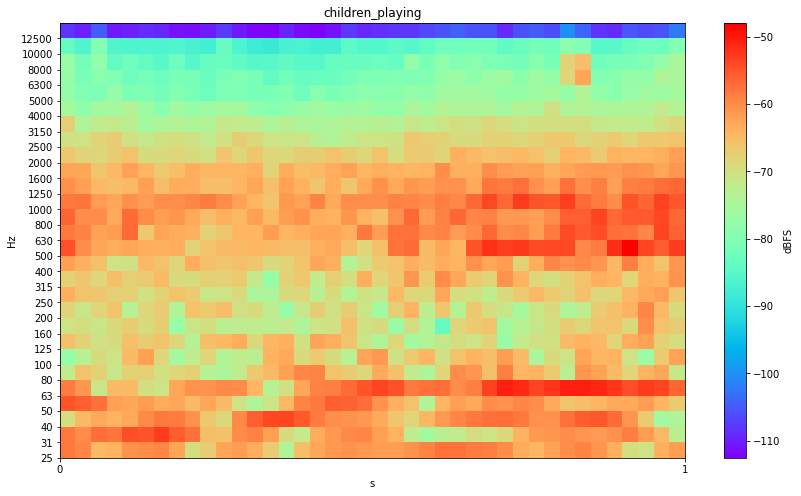

In [4]:
# sanity check:
print(df.shape)
o3p.oct_spectrogram(df[10000], 
                    param_dict['fs'], 
                    param_dict['frame_size'], 
                    param_dict['fmax'], 
                    param_dict['fmin'], 
                    param_dict['oct_bw_ratio'], 
                    labels[10000])

In [5]:
y, encoder = scale.label_encode(labels)
X, scaler = scale.data_scaler(df)
print(f'Encoded labels:\n{y}')
print(f'Shape of data frame: {X.shape}')
# Dividing data into training and Testing set
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2)


Encoded labels:
[0 0 0 ... 6 6 6]
Shape of data frame: (136620, 40, 28, 1)


In [6]:
# https://gist.github.com/jaron/5b17c9f37f351780744aefc74f93d3ae
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from sklearn import metrics

n_classes = max(y_test) + 1 # highest index + 1 is the amount of classes
print(f'Input shape: {X[0].shape}')
print(f'Output shape: {n_classes}')

layer_1 = [
    Conv2D(24, param_dict["kernel_size"], padding='same', input_shape=X[0].shape),
    MaxPooling2D(pool_size=param_dict["pool_size"]),
    Activation('relu')
]

layer_2 = [
    Conv2D(48, param_dict["kernel_size"], padding='same'),
    MaxPooling2D(pool_size=param_dict["pool_size"]),
    Activation('relu')
]

layer_3 = [
    Conv2D(48, param_dict["kernel_size"], padding='valid'),
    Activation('relu'),
]

layer_4 = [
    Flatten(),
    Dropout(0.5),
    Dense(64, kernel_regularizer=l2(0.001)),
    Activation('relu')
]

layer_5 = [
    Dropout(0.5),
    Dense(n_classes, kernel_regularizer=l2(0.001)),
    Activation('softmax')
]

layers = layer_1 + layer_2 + layer_3 + layer_4 + layer_5
model = Sequential(layers)

sgd = SGD(learning_rate=0.001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.fit(X_train, y_train, batch_size=param_dict["batch_size"], epochs=param_dict["epochs"])

Input shape: (40, 28, 1)
Output shape: 7
Epoch 1/50
2186/2186 [==============================] - 81s 37ms/step - loss: 2.0378 - accuracy: 0.1844
Epoch 2/50
2186/2186 [==============================] - 75s 35ms/step - loss: 1.9285 - accuracy: 0.2632
Epoch 3/50
2186/2186 [==============================] - 77s 35ms/step - loss: 1.7453 - accuracy: 0.3348
Epoch 4/50
2186/2186 [==============================] - 75s 34ms/step - loss: 1.6625 - accuracy: 0.3729
Epoch 5/50
2186/2186 [==============================] - 74s 34ms/step - loss: 1.6026 - accuracy: 0.4049
Epoch 6/50
2186/2186 [==============================] - 65s 30ms/step - loss: 1.5592 - accuracy: 0.42770s - loss: 1.5593 
Epoch 7/50
2186/2186 [==============================] - 66s 30ms/step - loss: 1.5268 - accuracy: 0.4447
Epoch 8/50
2186/2186 [==============================] - 65s 30ms/step - loss: 1.5024 - accuracy: 0.4580
Epoch 9/50
2186/2186 [==============================] - 64s 29ms/step - loss: 1.4813 - accuracy: 0.4684
Epoch

In [7]:
# determine the ROC AUC score 
y_prob = model.predict(X_test)
y_true = np.argmax(y_prob, 1)
roc = metrics.roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC: {round(roc,3)}")

score, accuracy = model.evaluate(X_test, y_test, batch_size=4)
print("\nAccuracy = {:.2f}".format(accuracy))

model.save(param_dict["CNN_name"])
conf.add_NN_description(param_dict)
conf.params2c("../STM32/C++/embedded_CNN_PoC_V-0-2/Core/Inc/params.h", param_dict)
conf.coeffs2c("../STM32/C++/embedded_CNN_PoC_V-0-2/Core/Inc/coeffs.h", param_dict)
conf.class_map2c("../STM32/C++/embedded_CNN_PoC_V-0-2/Core/Inc/class_map.h", param_dict)

ROC: 0.917
6831/6831 [==============================] - 10s 1ms/step - loss: 1.0752 - accuracy: 0.6294

Accuracy = 0.63
INFO:tensorflow:Assets written to: cnn_40_28_48k\assets


FileNotFoundError: [Errno 2] No such file or directory: '../STM32/C++/embedded_CNN_PoC_V-0-2/Core/Inc/params.h'

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(param_dict["CNN_name"] + "/" + param_dict["CNN_name"] + "_lite.tflite", "wb").write(tflite_model)